# Survival analysis on LOG_S_1.0mm small dataset

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.metrics import concordance_index_censored
from sklearn.base import BaseEstimator, RegressorMixin

### Initial glance on data

In [2]:
data = pd.read_excel('LOG_S_1.0mm.xlsx', sheet_name='Sheet 1')
data.head()

,A_LOG_1.0S_FO_10Percentile,A_LOG_1.0S_FO_90Percentile,A_LOG_1.0S_FO_Energy,A_LOG_1.0S_FO_Entropy,A_LOG_1.0S_FO_IQR,A_LOG_1.0S_FO_Kurtosis,A_LOG_1.0S_FO_Maximum,A_LOG_1.0S_FO_Mean,A_LOG_1.0S_FO_MAD,A_LOG_1.0S_FO_Median,...,E_shape_MajorAxis,E_shape_Maximum2DDiameterColumn,E_shape_Maximum2DDiameterRow,E_shape_Maximum2DDiameterSlice,E_shape_Maximum3DDiameter,E_shape_Sphericity,E_shape_SurfaceArea,E_shape_SurfaceVolumeRatio,censor,time
0,-112.993087,34.278236,1.497499e+07,1.950718,78.772847,2.963165,125.661385,-36.069763,45.916473,-32.176239,...,56.413789,110.143944,105.702865,111.731201,47.445347,0.295952,22991.047470,0.435628,1,4.734247
1,-91.982840,19.046037,1.456415e+06,1.733513,45.578664,6.254949,191.171707,-23.584620,35.662827,-11.017938,...,31.705678,47.186476,42.071600,48.412302,26.403203,0.447198,5349.092830,0.486225,1,18.345205
2,-24.633341,7.849291,4.955951e+05,0.966132,13.906203,8.346409,32.401775,-6.966859,10.458822,-4.591255,...,44.359603,41.168907,50.109743,56.818000,34.330462,0.417301,7627.193971,0.451720,1,10.586301
3,-27.706317,15.834357,7.741525e+06,1.168238,17.453013,11.841962,111.435387,-4.398507,14.461138,-1.749925,...,62.334907,69.090980,78.631173,78.631173,56.161281,0.567011,17162.509940,0.190129,1,20.712329
4,-195.595828,99.832056,3.896654e+08,2.882933,96.341311,7.102594,483.333252,-28.100289,91.166116,-7.814033,...,58.462737,60.018560,58.283554,62.152361,47.212345,0.607316,12445.462710,0.201418,1,10.356164


In [3]:
import lifelines

### Train Test Split

In [4]:
train_df, test_df = train_test_split(data, random_state=123)
train_df.head()

,A_LOG_1.0S_FO_10Percentile,A_LOG_1.0S_FO_90Percentile,A_LOG_1.0S_FO_Energy,A_LOG_1.0S_FO_Entropy,A_LOG_1.0S_FO_IQR,A_LOG_1.0S_FO_Kurtosis,A_LOG_1.0S_FO_Maximum,A_LOG_1.0S_FO_Mean,A_LOG_1.0S_FO_MAD,A_LOG_1.0S_FO_Median,...,E_shape_MajorAxis,E_shape_Maximum2DDiameterColumn,E_shape_Maximum2DDiameterRow,E_shape_Maximum2DDiameterSlice,E_shape_Maximum3DDiameter,E_shape_Sphericity,E_shape_SurfaceArea,E_shape_SurfaceVolumeRatio,censor,time
23,-136.326178,28.534787,5.929321e+07,2.146554,84.596703,5.674135,200.210709,-49.659627,53.198603,-39.628033,...,42.505107,51.677153,52.402224,53.707476,33.780387,0.269664,6493.473258,0.942441,1,47.309589
9,-72.800306,40.854950,3.109927e+07,1.711837,56.870411,4.237524,166.760513,-12.856040,36.687428,-7.558704,...,73.050068,114.147811,105.541063,115.011659,61.368132,0.440469,37824.603640,0.187054,1,14.728767
75,-164.492950,40.678913,3.857270e+08,2.429253,96.290200,5.138702,268.316315,-50.682658,65.163284,-35.914999,...,63.648332,77.259264,76.748082,83.593809,59.303064,0.314814,26047.684900,0.373044,1,11.243836
116,-307.195953,73.882935,6.998296e+07,3.312063,198.950063,4.621181,407.875977,-112.185588,123.633278,-93.440277,...,69.000674,71.245140,67.843479,72.123861,53.321172,0.466786,19873.790060,0.236542,0,9.271233
115,-140.765985,36.945937,1.381109e+08,2.259325,87.466111,4.180886,250.706039,-45.650616,56.254705,-37.681164,...,75.881498,97.264657,89.431930,104.682305,58.167516,0.426495,31576.815380,0.214868,1,5.030137


In [5]:
train_df.shape

(89, 430)

In [6]:
train_df["censor"].value_counts()

1    69
0    20
Name: censor, dtype: int64

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 23 to 109
Columns: 430 entries, A_LOG_1.0S_FO_10Percentile to time
dtypes: float64(424), int64(6)
memory usage: 299.7 KB


### Preprocessing 

In [8]:
passthrough_features = ["time"]
# don't want to scale tenure since it will be convenient to keep it in its original units of months.
target_column = ["censor"]

In [9]:
numeric_features = list(
    set(train_df.columns)
    - set(passthrough_features)
    - set(target_column)
)

In [10]:
# Using StandardScaler() to standardize numrical features
# We don't have categoritcal features

preprocessing_final = make_column_transformer(
    (
        FunctionTransformer(lambda x: x == 1),
        target_column,
    ), 
    ("passthrough", passthrough_features),
    (StandardScaler(), numeric_features)
)

In [11]:
preprocessing_final.fit(train_df);

### Get the column names of the columns created by the column transformer.

In [12]:
new_columns = (
    target_column
    + passthrough_features
    + numeric_features
)

In [13]:
train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [14]:
train_df_surv.head()

,censor,time,A_LOG_1.0S_GLRLM_GLNUN,Gender,T_shape_Sphericity,T_LOG_1.0S_GLRLM_LRE,A_LOG_1.0S_GLCM_SE,A_LOG_1.0S_GLCM_DV,E_LOG_1.0S_FO_Variance,E_LOG_1.0S_GLCM_DE,...,A_LOG_1.0S_FO_Energy,A_shape_SurfaceArea,N_LOG_1.0S_FO_Kurtosis,N_LOG_1.0S_GLRLM_LGLRE,T_LOG_1.0S_GLDM_HGLE,T_LOG_1.0S_GLCM_AC,A_LOG_1.0S_GLCM_CT,N_shape_Elongation,E_LOG_1.0S_GLRLM_RLNU,N_LOG_1.0S_FO_TE
23,1.0,47.309589,-0.330136,1.185498,-1.202305,-0.204074,0.316880,-0.267291,0.102330,0.413325,...,-0.212964,-0.516355,1.358338,-0.527353,0.000179,0.008019,-0.155779,-0.499140,-0.786421,-0.360470
9,1.0,14.728767,0.207580,-0.843527,1.068959,0.034598,-0.360721,-0.332919,-0.493397,-0.463889,...,-0.248199,0.313527,-0.234836,-0.302154,-0.472630,-0.477377,-0.348296,-0.997948,0.277851,-0.282749
75,1.0,11.243836,-0.670500,-0.843527,-0.836178,-0.218798,0.610658,0.010155,0.299988,0.589993,...,0.194992,1.879025,0.168270,-0.712498,0.358548,0.373710,-0.000917,1.172912,1.639388,0.167697
116,0.0,9.271233,-1.421337,-0.843527,0.771988,-1.204497,1.595650,1.321736,-0.171185,-0.062062,...,-0.199605,-1.013213,0.353218,-0.749648,1.179203,1.186953,0.982734,1.721911,-0.259008,-0.045593
115,1.0,5.030137,-0.522029,-0.843527,0.471427,-0.558054,0.348508,-0.161017,-0.361888,-0.461624,...,-0.114463,1.798049,-0.347658,-0.649460,-0.152352,-0.145818,-0.151268,0.143419,0.099233,0.205732


### Kaplan-Meier survival curve

#### I started with a model called KaplanMeierFitter.
#### I used this model to estimate the survival function. 

#### This model requires two columns: time and censor.

In [15]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(train_df_surv["time"], train_df_surv["censor"]);

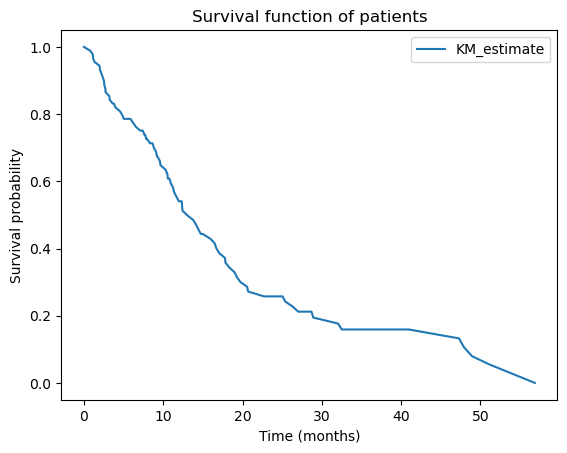

In [16]:
kmf.survival_function_.plot();
plt.title("Survival function of patients")
plt.xlabel("Time (months)")
plt.ylabel("Survival probability");

##### Average survival time

In [17]:
train_df_surv["time"].mean()

15.198276127786515

##### Average survival time for patients alive

In [18]:
train_df_surv.query("censor == 1.0")["time"].mean()

14.384752829666665

##### Average survival time for patients passed away

In [19]:
train_df_surv.query("censor == 0.0")["time"].mean()

18.004931506300004

#### Survial function with error bar

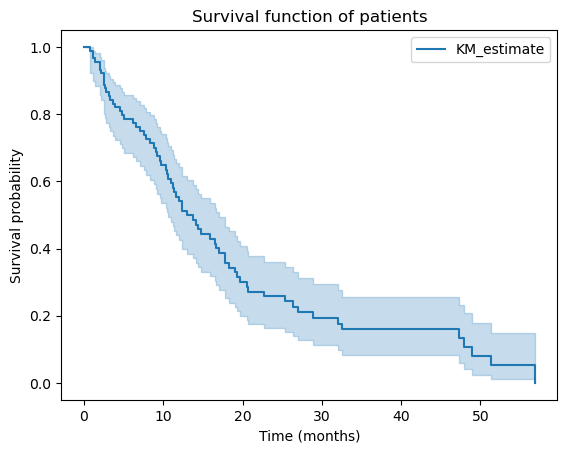

In [20]:
kmf.plot()
plt.title("Survival function of patients")
plt.xlabel("Time (months)")
plt.ylabel("Survival probability");

### Cox proportional hazards model

#### Feature selection

In [21]:
# Training set X
X_train_df = train_df.drop(["time", "censor"], axis=1)

# Training set y
event = train_df['censor']
time_to_event = train_df['time']
y_train_df = np.array(list(zip(event, time_to_event)), 
                    dtype=[('event', np.bool_), ('time_to_event', np.float64)])

### Features Selection

In [22]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1] 
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores



In [23]:
pipe = Pipeline(
    [
        ("scale", StandardScaler()),
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

In [24]:
print(len(X_train_df))

89


In [25]:
param_grid = {"select__k": np.arange(1, 30, 3)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_train_df, y_train_df)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,19,{'select__k': 19},0.718833,0.626298,0.598266,0.647799,0.051516,1,0.850917,0.781271,0.717647,0.783279,0.054426
4,13,{'select__k': 13},0.737401,0.619377,0.560694,0.639157,0.073484,2,0.849388,0.788107,0.702941,0.780145,0.060051
5,16,{'select__k': 16},0.724138,0.626298,0.560694,0.637043,0.067157,3,0.847859,0.785373,0.704412,0.779215,0.058724
7,22,{'select__k': 22},0.665782,0.588235,0.647399,0.633806,0.033085,4,0.836391,0.786056,0.797059,0.806502,0.021607
9,28,{'select__k': 28},0.663130,0.553633,0.673410,0.630058,0.054203,5,0.883028,0.797676,0.810294,0.830333,0.037615
3,10,{'select__k': 10},0.740053,0.557093,0.569364,0.622170,0.083506,6,0.837920,0.771018,0.699265,0.769401,0.056618
8,25,{'select__k': 25},0.700265,0.474048,0.638728,0.604347,0.095499,7,0.877676,0.808612,0.802206,0.829498,0.034167
2,7,{'select__k': 7},0.716180,0.463668,0.621387,0.600412,0.104149,8,0.837920,0.753247,0.691176,0.760781,0.060144
1,4,{'select__k': 4},0.671088,0.467128,0.578035,0.572083,0.083372,9,0.766055,0.744361,0.671324,0.727246,0.040523
0,1,{'select__k': 1},0.596817,0.463668,0.552023,0.537503,0.055319,10,0.665902,0.690021,0.648529,0.668151,0.017013


In [26]:
# Inspect the features with higher importance

def get_feature_coefs(pipe, best_params, data_x, data_y):
    # Set pipeline parameters
    pipe.set_params(**best_params)
    pipe.fit(data_x, data_y)

    # Extract the scale, transformer, and final estimator steps from the pipeline
    scale, transformer, final_estimator = [s[1] for s in pipe.steps]
    
    # Assuming the scaler doesn't change the order or number of columns
    scaled_feature_names = data_x.columns

    # Get boolean mask of the selected features from the transformer
    selected_mask = transformer.get_support()

    # Use the mask to filter the names of the scaled+selected features
    selected_feature_names = scaled_feature_names[selected_mask]

    # Create and return a pandas Series with the coefficients of the final estimator
    coefs = pd.Series(final_estimator.coef_, selected_feature_names)

    return coefs

In [27]:
coefs_series = get_feature_coefs(pipe, gcv.best_params_, X_train_df, y_train_df)

In [28]:
# Get the name of features that are more important
selected_column = list(coefs_series.index)
selected_column

['A_LOG_1.0S_GLCM_IDMN',
 'A_LOG_1.0S_GLCM_IDN',
 'A_LOG_1.0S_GLDM_GLNU',
 'A_LOG_1.0S_GLRLM_GLNU',
 'A_LOG_1.0S_GLSZM_LAHGLE',
 'A_LOG_1.0S_NGTDM_Coarseness',
 'A_LOG_1.0S_NGTDM_Contrast',
 'N_LOG_1.0S_GLSZM_SZNUN',
 'N_LOG_1.0S_GLSZM_SAE',
 'T_LOG_1.0S_GLDM_DNU',
 'T_LOG_1.0S_GLDM_GLNU',
 'T_LOG_1.0S_GLRLM_GLNU',
 'T_LOG_1.0S_NGTDM_Contrast',
 'KPS',
 'Age',
 'RTA',
 'T_shape_MinorAxis',
 'T_shape_Sphericity',
 'E_shape_Maximum2DDiameterSlice']

In [29]:
X_train_df_seleted = train_df_surv[selected_column]
X_train_df_seleted

,A_LOG_1.0S_GLCM_IDMN,A_LOG_1.0S_GLCM_IDN,A_LOG_1.0S_GLDM_GLNU,A_LOG_1.0S_GLRLM_GLNU,A_LOG_1.0S_GLSZM_LAHGLE,A_LOG_1.0S_NGTDM_Coarseness,A_LOG_1.0S_NGTDM_Contrast,N_LOG_1.0S_GLSZM_SZNUN,N_LOG_1.0S_GLSZM_SAE,T_LOG_1.0S_GLDM_DNU,T_LOG_1.0S_GLDM_GLNU,T_LOG_1.0S_GLRLM_GLNU,T_LOG_1.0S_NGTDM_Contrast,KPS,Age,RTA,T_shape_MinorAxis,T_shape_Sphericity,E_shape_Maximum2DDiameterSlice
23,1.089218,1.105450,-0.403510,-0.352690,-0.308188,-0.266033,-0.440491,0.071310,0.342011,-0.393864,-0.371979,-0.390828,-0.487669,-1.150645,0.316255,0.394771,0.035982,-1.202305,-1.371658
9,-0.363376,-0.640722,0.228627,0.240777,-0.000957,-0.480265,-0.429602,-0.034197,0.214382,-0.230892,0.185620,0.140155,-0.419353,0.233239,1.448161,0.394771,0.516307,1.068959,1.631766
75,0.773688,0.633651,1.417608,1.759501,1.227887,-0.581105,-0.556394,-0.795380,-0.488770,1.197873,1.434819,1.566287,-0.548146,-2.534529,-0.362888,0.394771,2.165783,-0.836178,0.092538
116,-0.059739,-0.703713,-0.947857,-0.949391,-0.547043,0.770154,2.328850,1.914900,1.481033,-0.605876,-1.016019,-0.980753,3.665206,0.233239,-0.061047,0.394771,-1.567993,0.771988,-0.469400
115,0.418901,0.138867,0.271637,0.406321,-0.090395,-0.497118,-0.488038,-0.607251,-0.294281,0.184242,0.286750,0.383160,-0.487029,0.233239,1.146319,0.394771,1.450588,0.471427,1.125709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,-2.039483,-0.801748,-0.675424,-0.773315,-0.518727,0.617556,0.889132,-0.548166,-0.450609,-0.708452,-0.806224,-0.835537,0.636584,-1.150645,0.316255,-2.533114,-1.362093,1.620525,-2.321144
98,0.207460,0.181392,0.344412,0.300448,-0.247489,-0.437365,-0.479932,-0.988270,-0.630570,-0.323795,0.136937,0.127220,-0.509268,0.233239,0.844478,0.394771,1.594084,-1.321183,1.180110
92,-1.248476,0.076753,-0.265680,-0.301433,-0.465170,0.223046,-0.222718,-0.407333,-0.232035,-0.545220,-0.494536,-0.451139,0.030220,0.233239,-2.702160,0.394771,-0.517631,-1.487931,-0.068221
66,1.211141,1.237752,1.430225,2.003942,0.257989,-0.612217,-0.563774,0.934149,0.946459,5.415701,2.791650,3.424455,-0.567664,0.233239,-1.042031,0.394771,2.604417,-0.542711,1.347863


In [30]:
X_test_df = test_df_surv.drop(["time", "censor"], axis=1)[selected_column]
event = test_df_surv['censor']
time = test_df_surv['time']

# Convert to structured array
y_test_df = np.array(list(zip(event, time_to_event)), 
                    dtype=[('event', np.bool_), ('time_to_event', np.float64)])

### Hyperparameter Tuning

In [31]:
import warnings
warnings.filterwarnings("ignore")

class CoxPHSurvivalAnalysisWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.model = CoxPHSurvivalAnalysis(alpha=self.alpha)
    
    def fit(self, X, y):
        event, time = y['event'], y['time_to_event']
        structured_y = np.array([(e, t) for e, t in zip(event, time)], dtype=[('event', '?'), ('time', '<f8')])
        self.model.fit(X, structured_y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)

X_train_df_seleted = X_train_df_seleted.apply(pd.to_numeric, errors='coerce')

param_grid = {'alpha': [0.001, 0.001, 0.01, 0.1, 1.0, 10.0]}
coxph = CoxPHSurvivalAnalysisWrapper()
gsearch = GridSearchCV(coxph, param_grid, cv=5)
gsearch.fit(X_train_df_seleted, y_train_df)

print("Best alpha:", gsearch.best_params_)

Best alpha: {'alpha': 0.001}


#### Using the best parameter to fit the model

In [32]:
cph = CoxPHSurvivalAnalysis(alpha = 0.001)
cph.fit(X_train_df_seleted, y_train_df)

CoxPHSurvivalAnalysis(alpha=0.001)

#### Coefficients learned by the model and start interpreting

In [33]:
cph_params = pd.DataFrame(cph.coef_).apply(pd.to_numeric, errors='coerce')
cph_names = pd.DataFrame(cph.feature_names_in_)
cph_param_coef = pd.concat([cph_names, cph_params], axis=1)
cph_param_coef.columns = ['Feature', 'Coefficient']
cph_param_coef

,Feature,Coefficient
0,A_LOG_1.0S_GLCM_IDMN,0.849403
1,A_LOG_1.0S_GLCM_IDN,-0.567159
2,A_LOG_1.0S_GLDM_GLNU,0.451343
3,A_LOG_1.0S_GLRLM_GLNU,-0.451312
4,A_LOG_1.0S_GLSZM_LAHGLE,-0.062368
5,A_LOG_1.0S_NGTDM_Coarseness,0.276898
6,A_LOG_1.0S_NGTDM_Contrast,-0.256067
7,N_LOG_1.0S_GLSZM_SZNUN,0.719985
8,N_LOG_1.0S_GLSZM_SAE,-1.501891
9,T_LOG_1.0S_GLDM_DNU,0.333175


### Top 5 "positive" features: The larger these variables are, the less likely the patient are going to survive longer. (Bad feature)

In [34]:
sorted_coefficients = cph_param_coef.sort_values(by='Coefficient', ascending=False)
top_5_coefficients = sorted_coefficients.head(5)
top_5_coefficients

,Feature,Coefficient
0,A_LOG_1.0S_GLCM_IDMN,0.849403
7,N_LOG_1.0S_GLSZM_SZNUN,0.719985
16,T_shape_MinorAxis,0.517027
14,Age,0.475903
2,A_LOG_1.0S_GLDM_GLNU,0.451343


### Top 5 "negative" features: The larger these variables are, the more likely the patient are going to survive longer. (Good feature)

In [35]:
bottom_5_coefficients = sorted_coefficients.tail(5)
bottom_5_coefficients

,Feature,Coefficient
6,A_LOG_1.0S_NGTDM_Contrast,-0.256067
3,A_LOG_1.0S_GLRLM_GLNU,-0.451312
1,A_LOG_1.0S_GLCM_IDN,-0.567159
15,RTA,-0.794158
8,N_LOG_1.0S_GLSZM_SAE,-1.501891


## Prediction

#### I hope to know the quality of my model

#### I used concordance-index, also known as the c-index to evaluate my model. I chose to use it because it is censoring-sensitive.

##### From the documentation:
**0.5** is the expected result from random predictions, <br />
**1.0** is perfect concordance <br />
**0.0** is perfect anti-concordance

### On training set:

In [36]:
cph.score(X_train_df_seleted, y_train_df)

0.8319974350753446

##### This indicates that the model has an excellent fit to the training data.

### On testing set:

In [37]:
cph.score(X_test_df, y_test_df)

0.5322128851540616

##### This value is significantly lower than the training score, indicating that the model's performance drops when predicting on unseen data.

### The large discrepancy between the training and testing scores suggests that the model might be **overfitting** to the training data.

### More actions could be taken to address this overfitting issue. One measure I could think of is to increase the sample size. Now we have only about 120 observations, which is probably too small for training a good model.